# Classification Network

The goal here is to classify whether the error rate is "low" "medium" or "high".
If we can successfully do this, then look at whether we can get the sign right. Start off by using the squeezenet model.


In [2]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


Loading data...
Pre-processing data...
0.0008525078358
Organizing train/val split...
Visualizing data...
Training vs. Validation sets:


/home/cs231n/myVE35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cs231n/myVE35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cs231n/myVE35/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cs231n/myVE35/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cs231n/myVE35/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


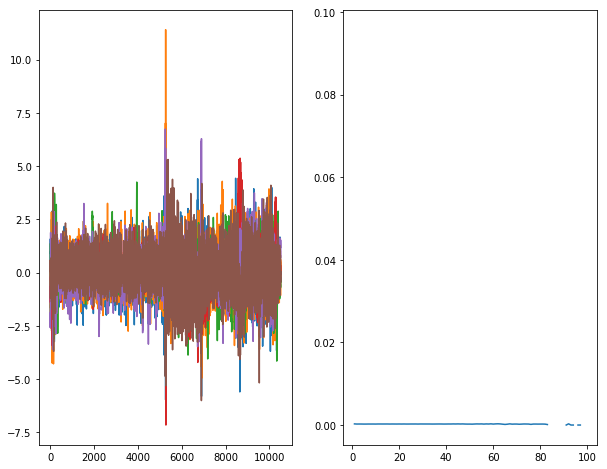

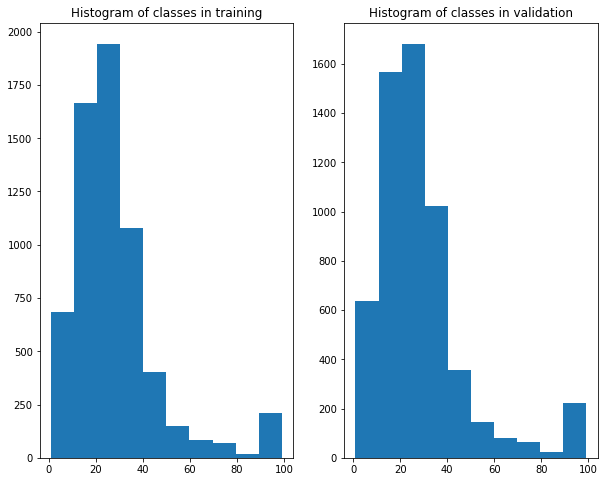

In [5]:
# Load data
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
print('Loading data...')
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T

# Should really automate this... or just re-save file.
flows_data = []
flows_data.append(np.load('flows_lowres_1_16.npy'))
flows_data.append(np.load('flows_lowres_2_16.npy'))
flows_data.append(np.load('flows_lowres_3_16.npy'))
flows_data.append(np.load('flows_lowres_4_16.npy'))
flows_data.append(np.load('flows_lowres_5_16.npy'))
flows_data.append(np.load('flows_lowres_6_16.npy'))
flows_data.append(np.load('flows_lowres_7_16.npy'))
flows_data.append(np.load('flows_lowres_8_16.npy'))
flows_data.append(np.load('flows_lowres_9_16.npy'))
flows_data.append(np.load('flows_lowres_10_16.npy'))
flows_data.append(np.load('flows_lowres_11_16.npy'))
flows_data.append(np.load('flows_lowres_12_16.npy'))
flows_data.append(np.load('flows_lowres_13_16.npy'))
flows_data.append(np.load('flows_lowres_14_16.npy'))
flows_data.append(np.load('flows_lowres_15_16.npy'))
#flows_data.append(np.load('flows_lowres_16_16.npy'))
flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:,:]


print('Pre-processing data...')
# Shorten datastream:
i_start = 0 # remove initial weird-ness
i_end = flows_data.shape[0]
y_raw = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:,:]


# Convert y_data into classes:
y_norm = np.zeros(y_raw.shape[0]);
for k in range(y_raw.shape[0]):
    y_norm[k]=np.linalg.norm(y_raw[k,:])

NUM_CLASSES = 100
y_std = np.min(np.abs(y_norm))
print(y_std)

y_data = np.zeros_like(y_norm)
for k in range(y_norm.shape[0]):
    y_data[k] = np.int(np.min([NUM_CLASSES-1,y_norm[k]/y_std]))
    
    
# Compute statistics: 
mean_vals= np.zeros(NUM_CLASSES)
std_vals = np.zeros(NUM_CLASSES)
for k in range(NUM_CLASSES):
    indices = np.where(y_data==k)
    mean_vals[k] = np.mean(y_norm[indices])
    std_vals[k] = np.std(y_norm[indices])


# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
flows_data -= flows_data.mean(axis=0)
flows_data /= np.std(flows_data,axis=0)

print('Organizing train/val split...')
N_training = int(0.6*flows_data.shape[0])
N_validation = flows_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)


# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(batch_size, train=True,iseq=None):
    x_img_batch = np.zeros((batch_size, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros(batch_size)
    
    if(iseq is None):
        # randomly sample endpoint:
        # choose which subsequence to sample from: 
        if(train):
            i_vals = training_data_indices[np.random.randint(0,N_training,batch_size)]
        else:
            i_vals = validation_data_indices[np.random.randint(0,N_validation,batch_size)]
            i_stop = 0
    else:
        i_vals = i_seq
    y_batch = y_data[i_vals]
    x_img_batch = flows_data[i_vals,:,:,:]
    return x_img_batch, y_batch

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

print('Visualizing data...')
print('Training vs. Validation sets:')
plt.subplot(1,2,1)
plt.plot(imu_data)
plt.subplot(1,2,2)
plt.plot(std_vals)
plt.show()

plt.subplot(1,2,1)
plt.hist(y_data[training_data_indices])
plt.title('Histogram of classes in training')
plt.subplot(1,2,2)
plt.hist(y_data[validation_data_indices])
plt.title('Histogram of classes in validation')
plt.show()

In [11]:
BATCH_SIZE = 64

def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)

    # input is a factor of 3 skinnier and 4 shorter than expected. So pool less by a factor of 3 and 4?
    # 13x13
    # 4x3

class SqueezeNet(object):
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('layer0'):
                W = tf.get_variable("weights",shape=[3,3,2,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('layer1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer3'):
                x = fire_module(x,64,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer4'):
                x = fire_module(x,128,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer5'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer6'):
                x = fire_module(x,128,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer7'):
                x = fire_module(x,256,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer8'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer9'):
                x = fire_module(x,256,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer10'):
                x = fire_module(x,384,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer11'):
                x = fire_module(x,384,64,256,256)
                layers.append(x)
            with tf.variable_scope('layer12'):
                x = fire_module(x,512,64,256,256)
                layers.append(x)
        return layers

    def __init__(self, save_path=None, sess=None):
        """Create a SqueezeNet model.
        Inputs:
        - save_path: path to TensorFlow checkpoint
        - sess: TensorFlow session
        """
        self.image = tf.placeholder('float',shape=[None,None,None,2],name='input_image')
        self.labels = tf.placeholder('int32', shape=[None], name='labels')
        self.lr = tf.placeholder('float',shape=[1],name='lr')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('classifier'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'):
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.relu(x)
                self.layers.append(x)
            with tf.variable_scope('layer3'):
                x = tf.nn.avg_pool(x,[1,2,3,1],strides=[1,2,1,1],padding='VALID')
                self.layers.append(x)
# NOT really squeezenet, but ...
            with tf.variable_scope('layer4'):
                x = tf.layers.dense(x, NUM_CLASSES,activation=tf.nn.relu)
                self.layers.append(x)
        self.classifier = tf.reshape(x,[BATCH_SIZE, NUM_CLASSES])

        if save_path is not None:
            saver = tf.train.Saver()
#            saver = tf.train.import_meta_graph(save_path*'.meta')
            saver.restore(sess, save_path)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, NUM_CLASSES), logits=self.classifier))
        self.prediction = tf.cast(tf.argmax(self.classifier,1),'int32')
        self.acc = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.labels),tf.float32))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.loss)


Step:  2  Train:  0.0  Val:  0.0 LR:  0.004


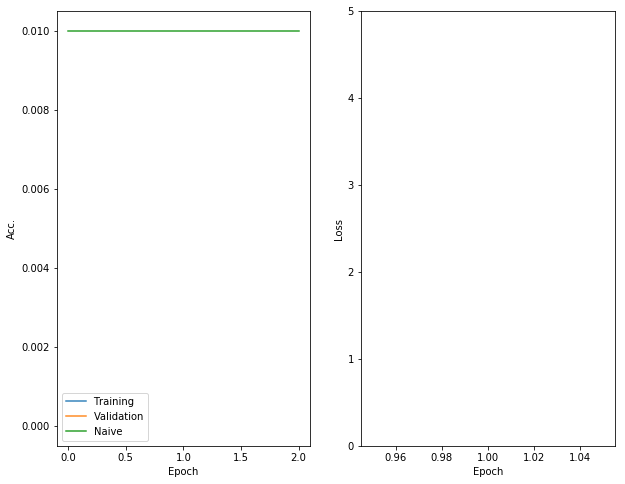

Step:  3  Train:  0.0625  Val:  0.015625 LR:  0.004


Step:  4  Train:  0.03125  Val:  0.0 LR:  0.004


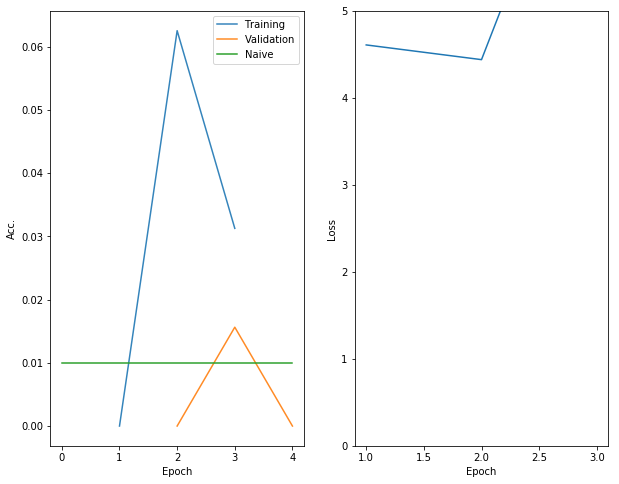

Step:  5  Train:  0.015625  Val:  0.0 LR:  0.004


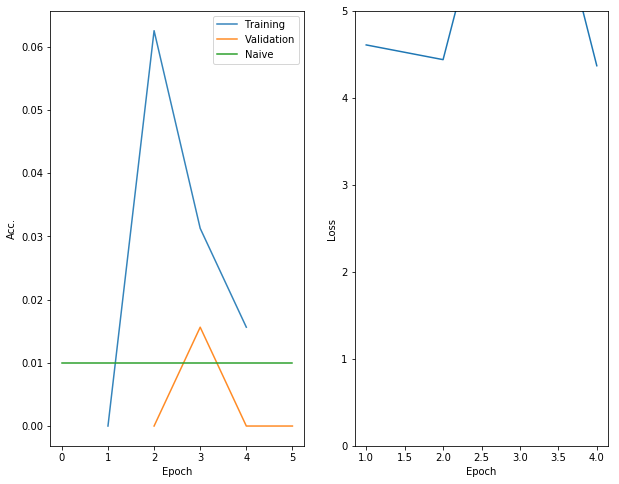

Step:  6  Train:  0.046875  Val:  0.03125 LR:  0.004


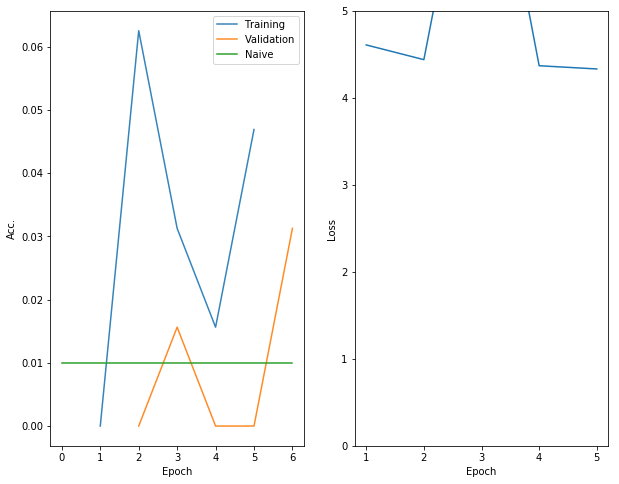

Step:  7  Train:  0.015625  Val:  0.046875 LR:  0.004


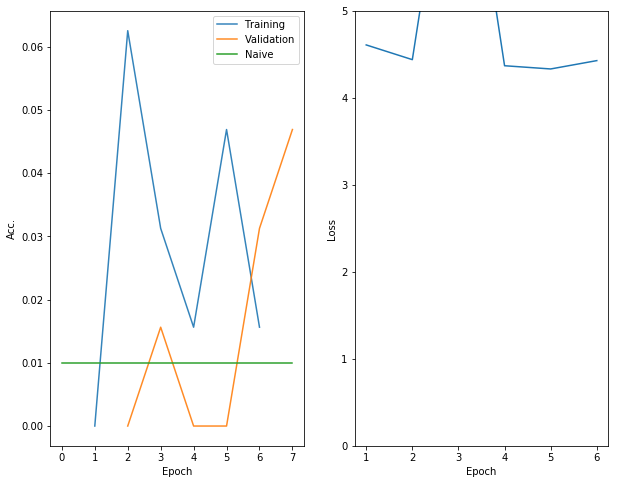

Step:  8  Train:  0.03125  Val:  0.03125 LR:  0.004


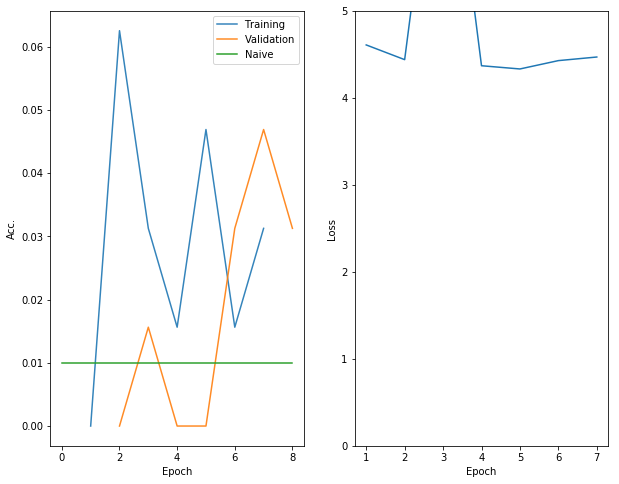

Step:  9  Train:  0.046875  Val:  0.046875 LR:  0.004


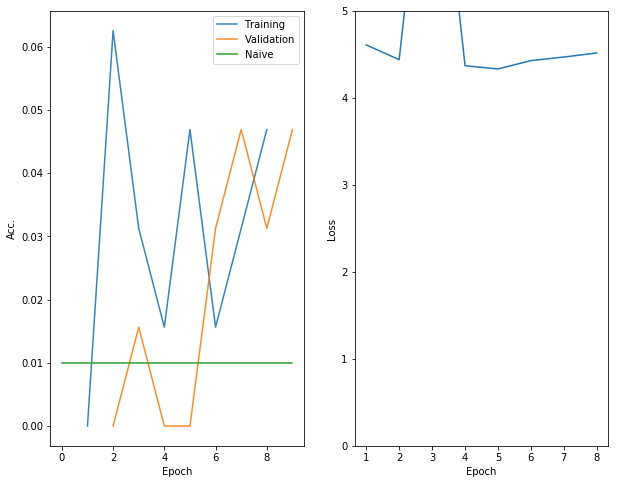

Step:  10  Train:  0.03125  Val:  0.0625 LR:  0.004


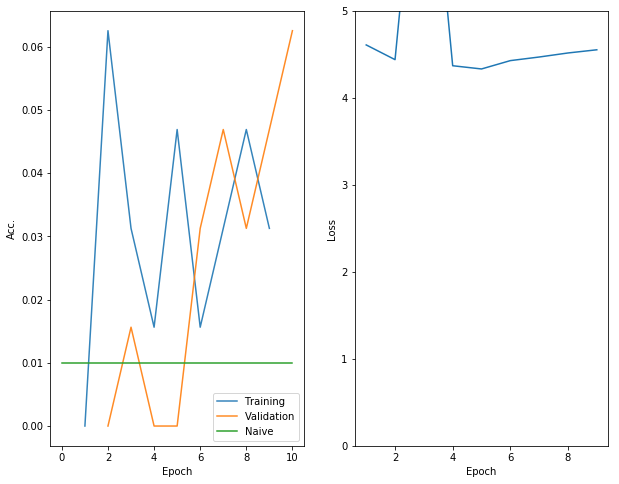

Step:  11  Train:  0.03125  Val:  0.046875 LR:  0.004


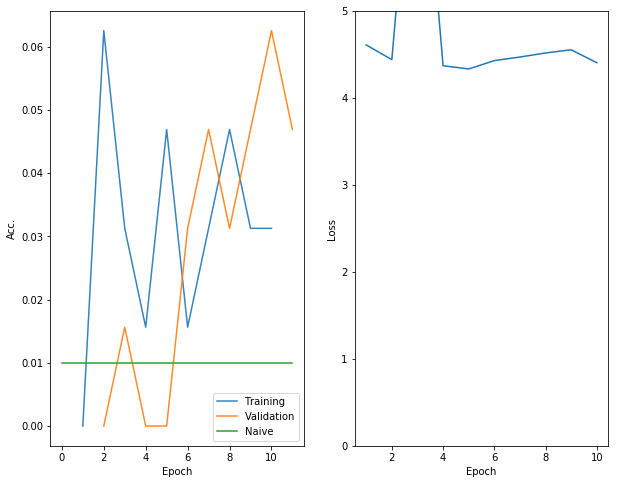

Step:  12  Train:  0.0  Val:  0.03125 LR:  0.004


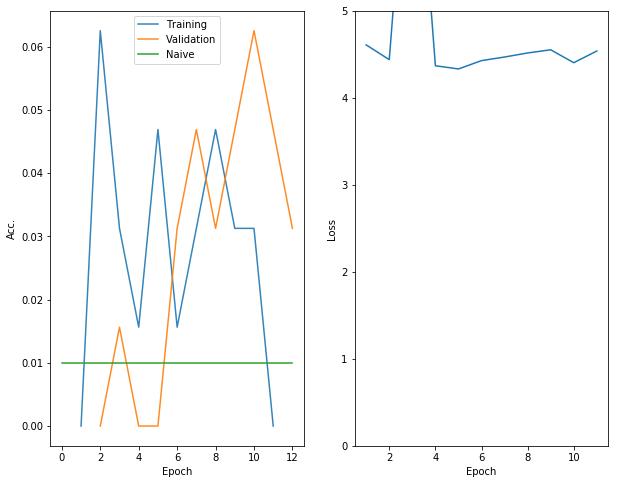

Step:  13  Train:  0.046875  Val:  0.015625 LR:  0.004


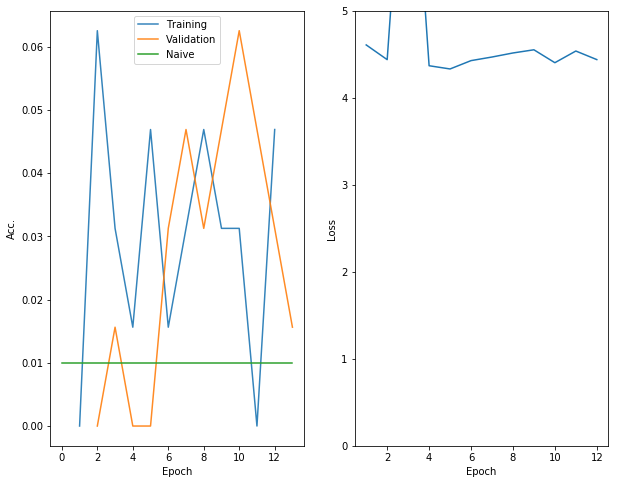

Step:  14  Train:  0.046875  Val:  0.03125 LR:  0.004


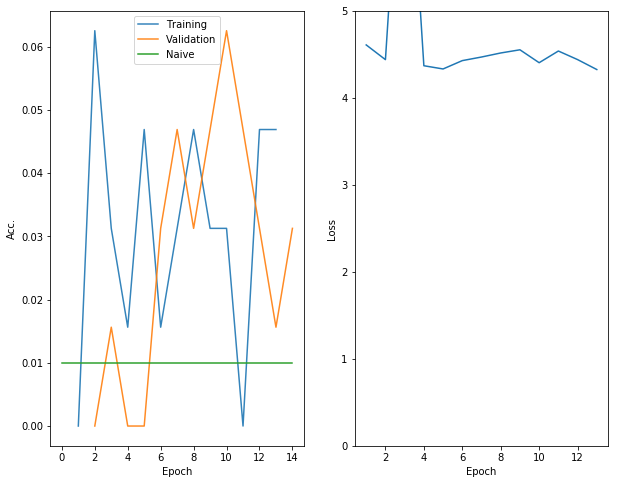

Step:  15  Train:  0.015625  Val:  0.015625 LR:  0.004


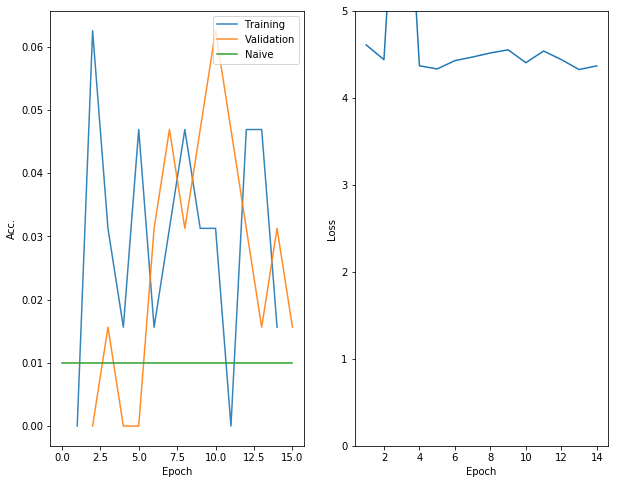

Step:  16  Train:  0.046875  Val:  0.0 LR:  0.004


Step:  17  Train:  0.03125  Val:  0.0625 LR:  0.004


Step:  18  Train:  0.015625  Val:  0.0 LR:  0.004


Step:  19  Train:  0.0  Val:  0.046875 LR:  0.004


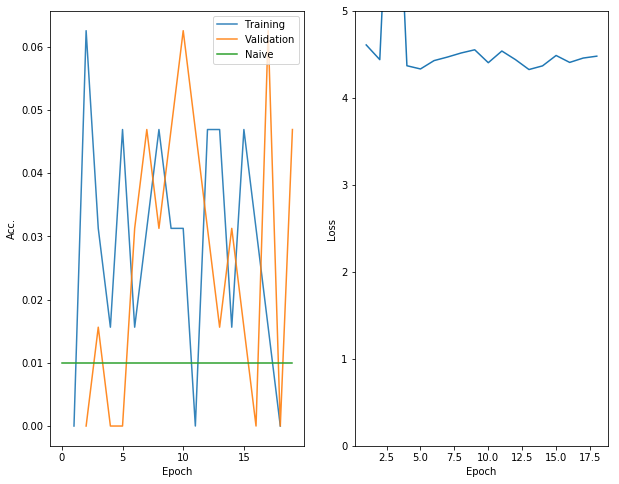

Step:  20  Train:  0.046875  Val:  0.015625 LR:  0.004


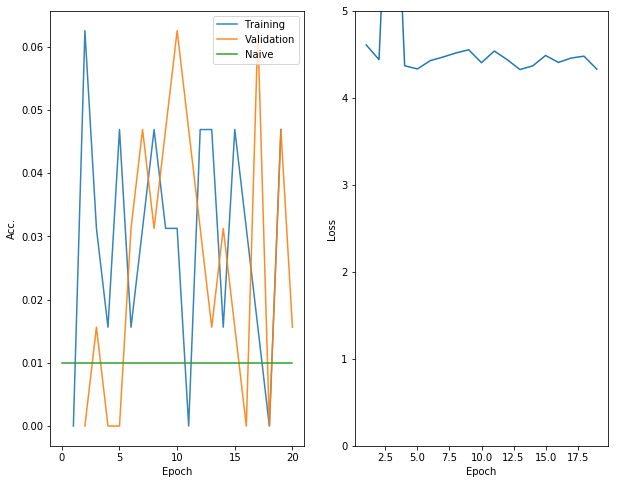

Step:  21  Train:  0.046875  Val:  0.015625 LR:  0.004


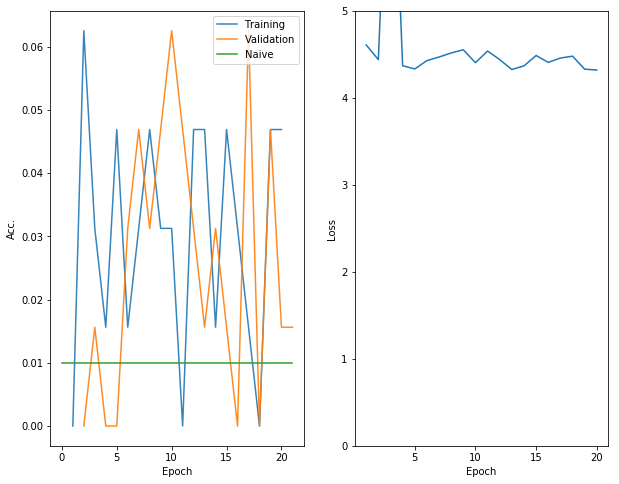

Step:  22  Train:  0.0625  Val:  0.0 LR:  0.004


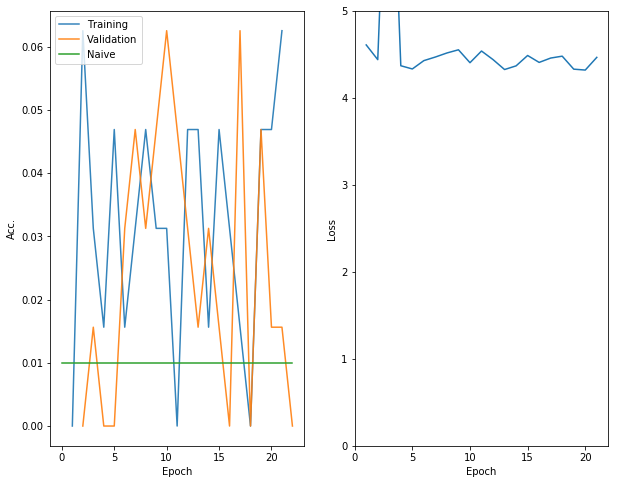

Step:  23  Train:  0.09375  Val:  0.0 LR:  0.004


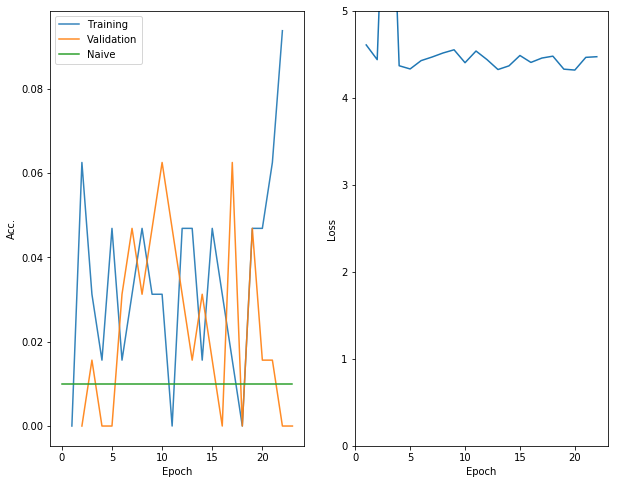

Step:  24  Train:  0.046875  Val:  0.015625 LR:  0.004


Step:  25  Train:  0.0  Val:  0.046875 LR:  0.004


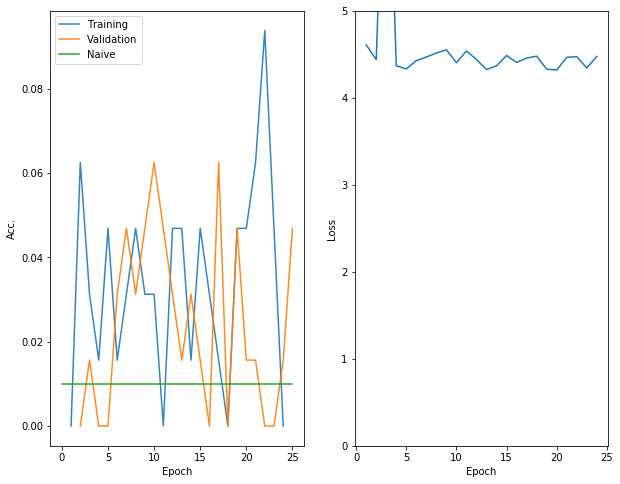

Step:  26  Train:  0.03125  Val:  0.015625 LR:  0.004


Step:  27  Train:  0.046875  Val:  0.03125 LR:  0.004


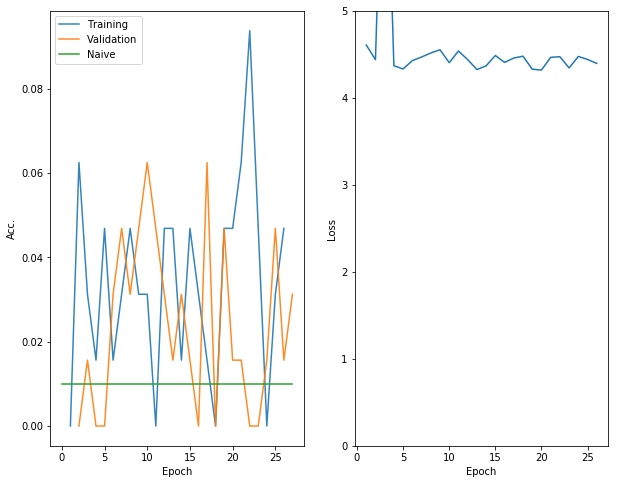

Step:  28  Train:  0.0625  Val:  0.0 LR:  0.004


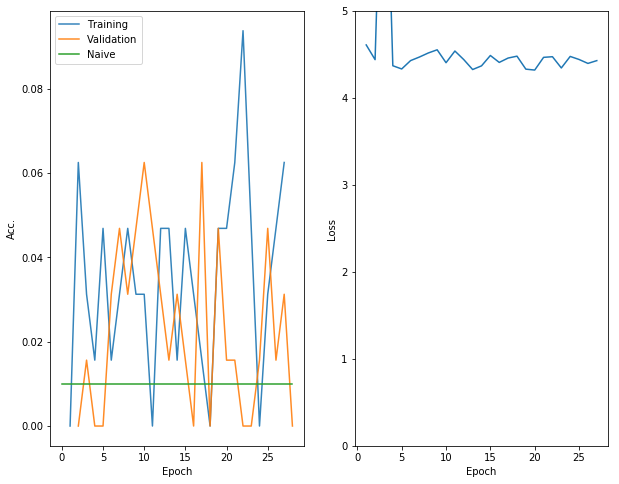

Step:  29  Train:  0.078125  Val:  0.015625 LR:  0.004


Step:  30  Train:  0.03125  Val:  0.015625 LR:  0.004


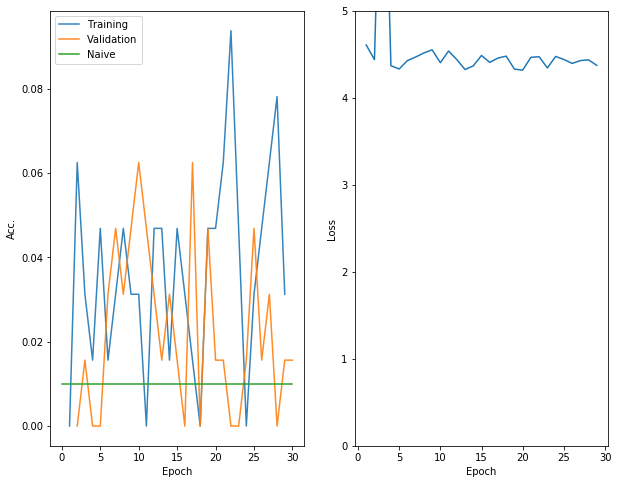

Step:  31  Train:  0.0  Val:  0.0 LR:  0.00396


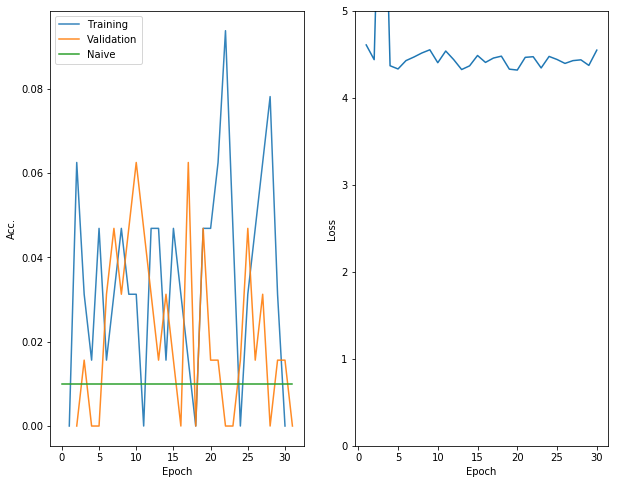

Step:  32  Train:  0.046875  Val:  0.0 LR:  0.00396


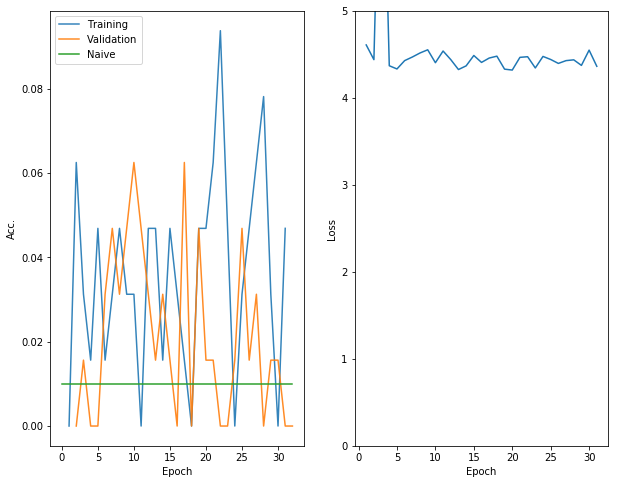

Step:  33  Train:  0.03125  Val:  0.078125 LR:  0.00396


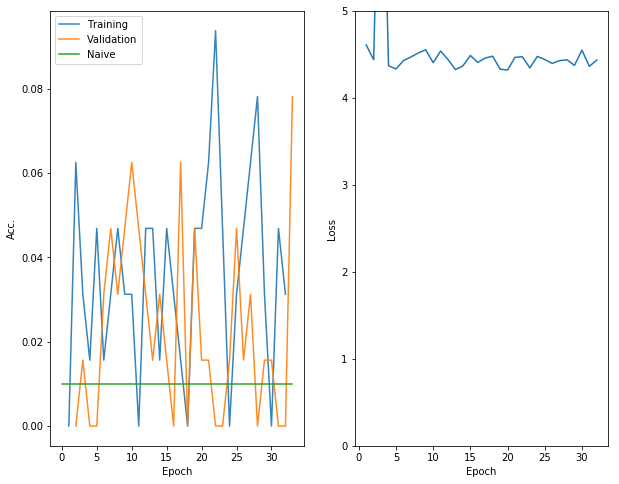

Step:  34  Train:  0.03125  Val:  0.015625 LR:  0.00396


Step:  35  Train:  0.015625  Val:  0.03125 LR:  0.00396


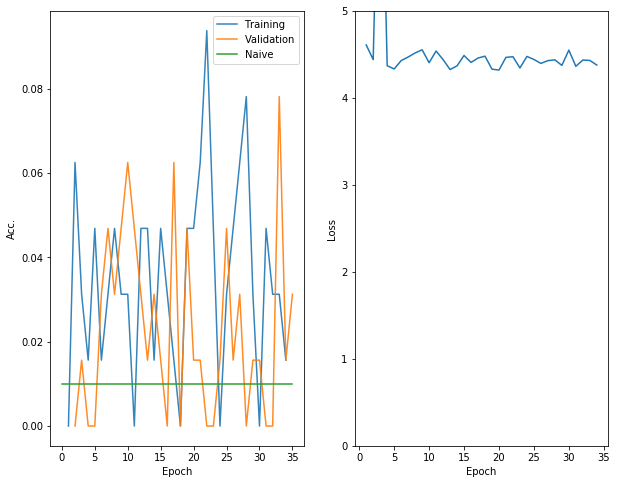

Step:  36  Train:  0.0  Val:  0.03125 LR:  0.00396


Step:  37  Train:  0.03125  Val:  0.03125 LR:  0.00396


Step:  38  Train:  0.015625  Val:  0.015625 LR:  0.00396


Step:  39  Train:  0.015625  Val:  0.015625 LR:  0.00396


Step:  40  Train:  0.03125  Val:  0.015625 LR:  0.00396


Step:  41  Train:  0.03125  Val:  0.046875 LR:  0.00396


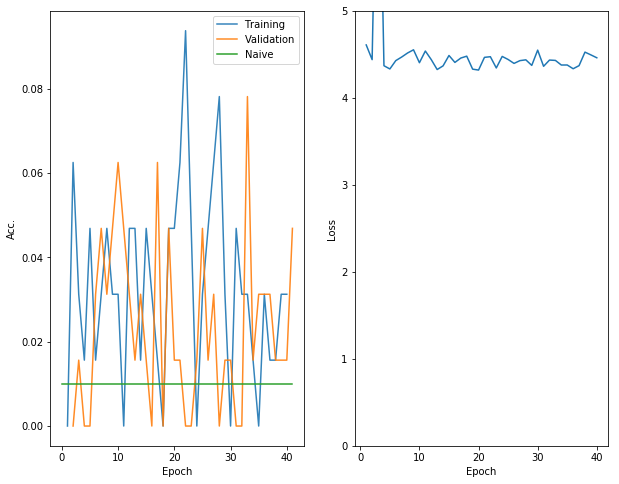

Step:  42  Train:  0.015625  Val:  0.03125 LR:  0.00396


Step:  43  Train:  0.0  Val:  0.046875 LR:  0.00396


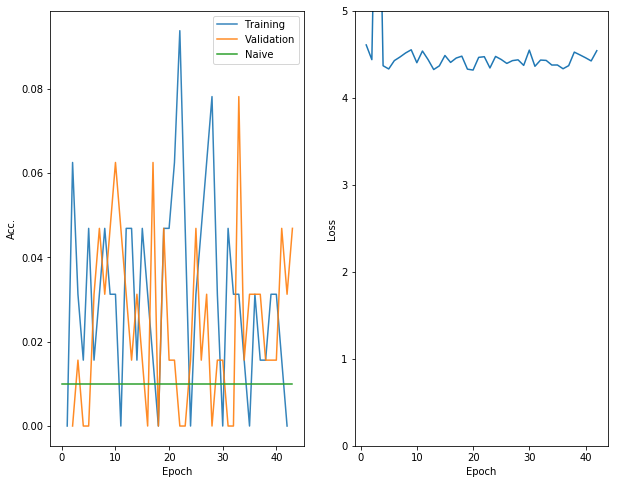

Step:  44  Train:  0.03125  Val:  0.046875 LR:  0.00396


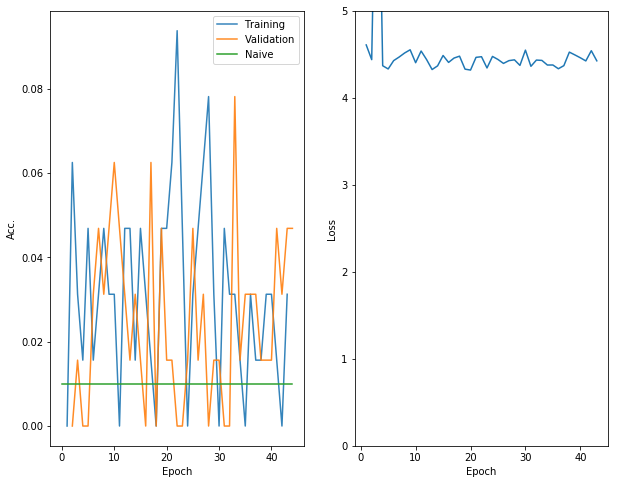

Step:  45  Train:  0.015625  Val:  0.015625 LR:  0.00396


Step:  46  Train:  0.03125  Val:  0.015625 LR:  0.00396


Step:  47  Train:  0.046875  Val:  0.03125 LR:  0.00396


Step:  48  Train:  0.046875  Val:  0.0625 LR:  0.00396


Step:  49  Train:  0.015625  Val:  0.046875 LR:  0.00396


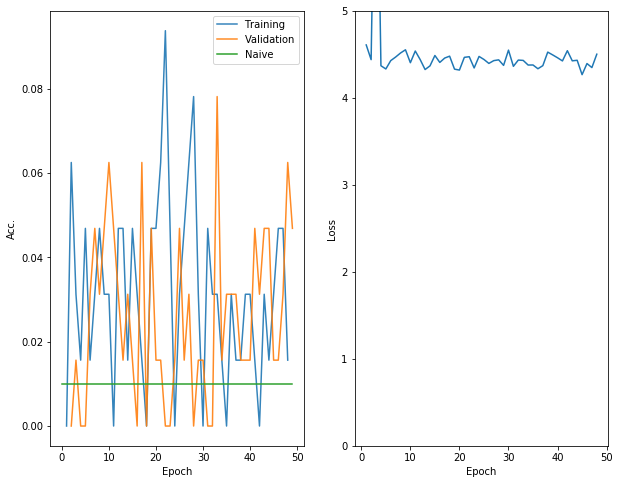

Step:  50  Train:  0.03125  Val:  0.078125 LR:  0.00396


Step:  51  Train:  0.03125  Val:  0.03125 LR:  0.00396


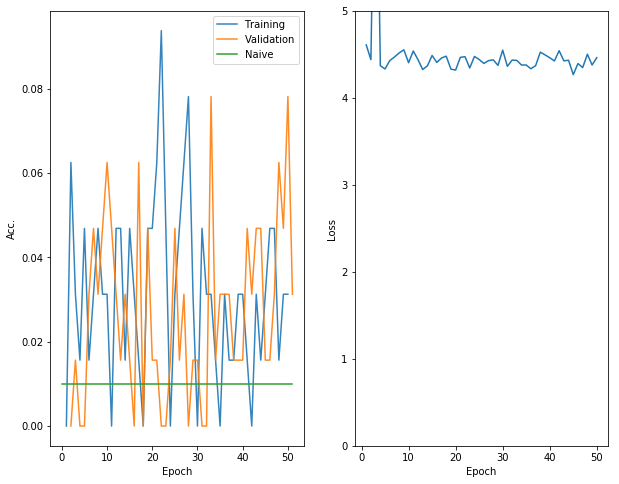

Step:  52  Train:  0.046875  Val:  0.015625 LR:  0.00396


Step:  53  Train:  0.015625  Val:  0.03125 LR:  0.00396


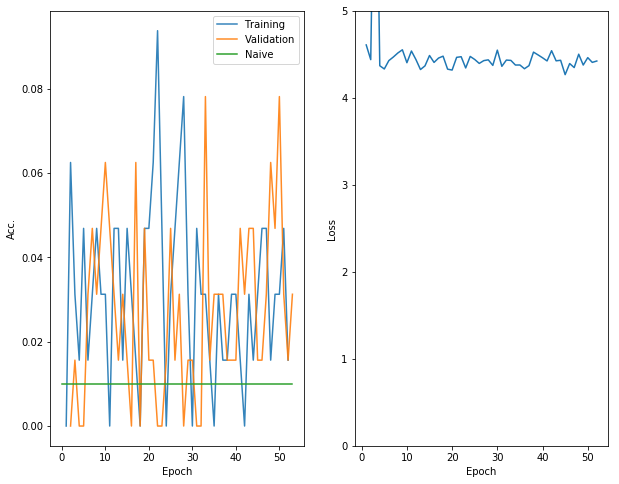

Step:  54  Train:  0.015625  Val:  0.015625 LR:  0.00396


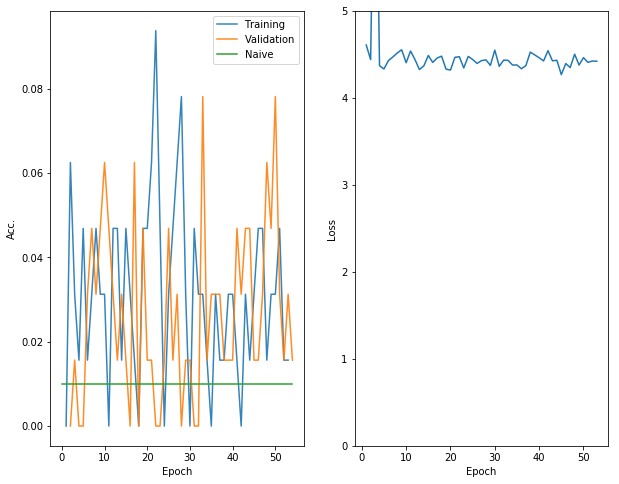

Step:  55  Train:  0.015625  Val:  0.03125 LR:  0.00396


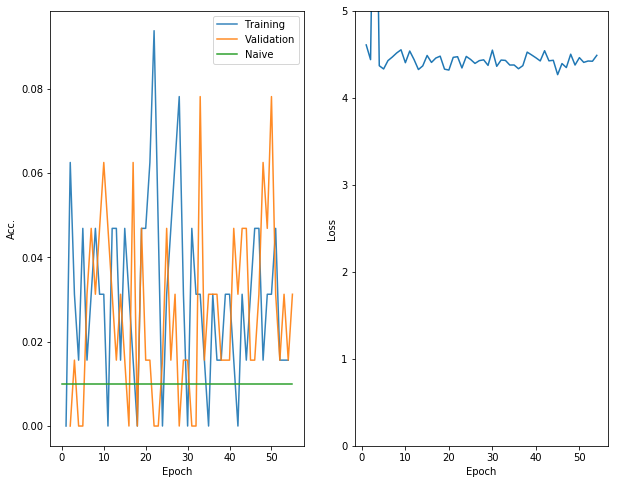

Step:  56  Train:  0.03125  Val:  0.046875 LR:  0.00396


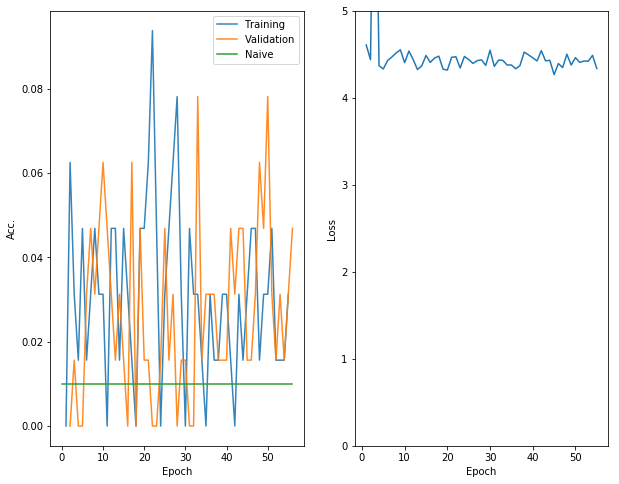

Step:  57  Train:  0.015625  Val:  0.015625 LR:  0.00396


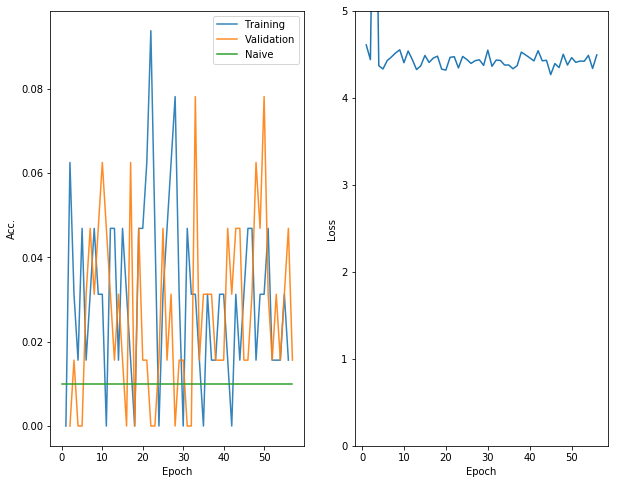

Step:  58  Train:  0.0625  Val:  0.015625 LR:  0.00396


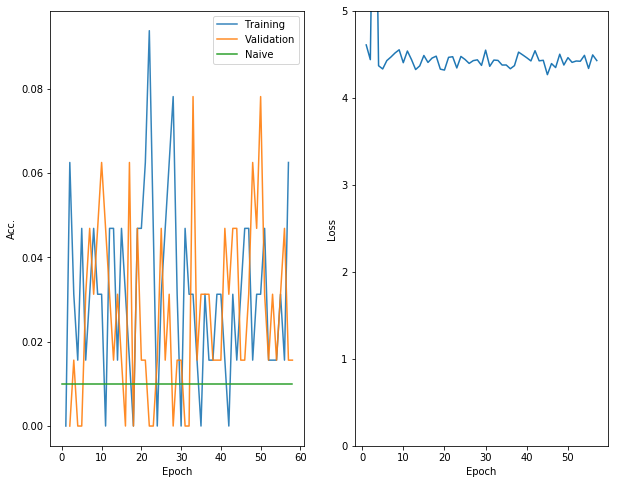

Step:  59  Train:  0.03125  Val:  0.03125 LR:  0.00396


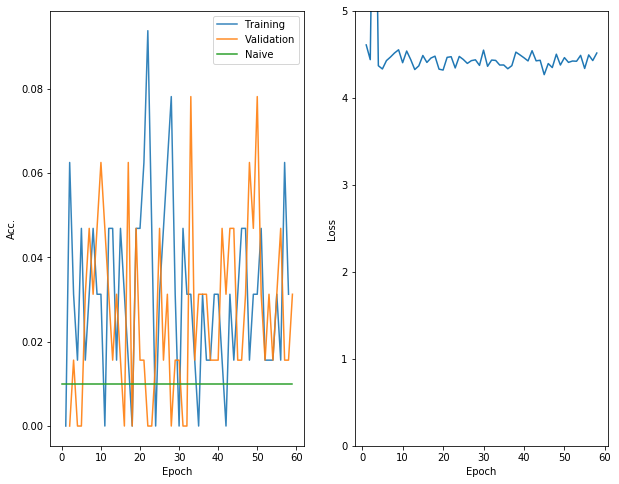

Step:  60  Train:  0.0625  Val:  0.03125 LR:  0.00396


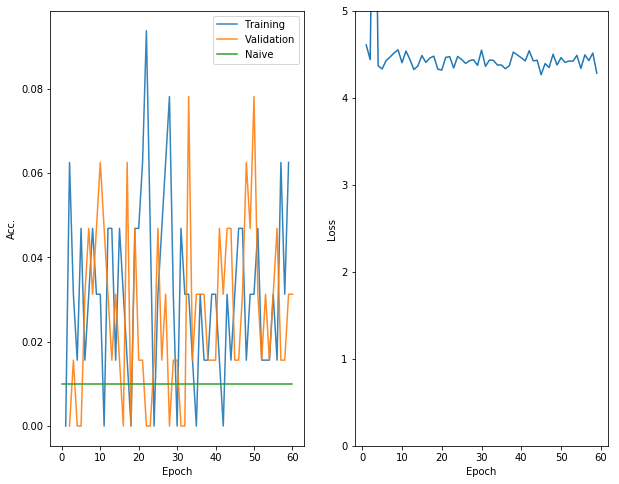

Step:  61  Train:  0.015625  Val:  0.015625 LR:  0.0039204


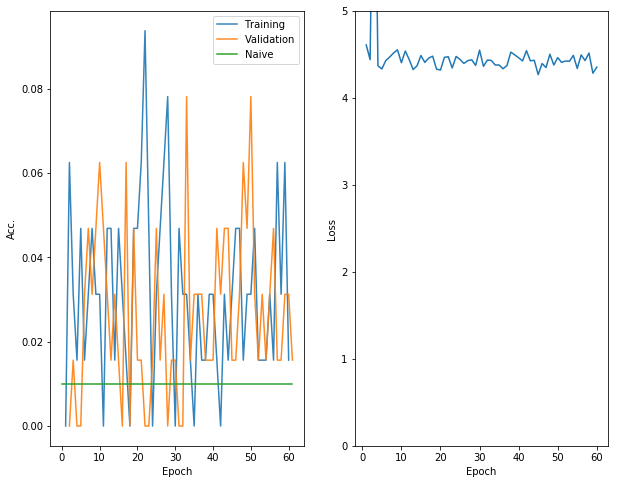

Step:  62  Train:  0.078125  Val:  0.0 LR:  0.0039204


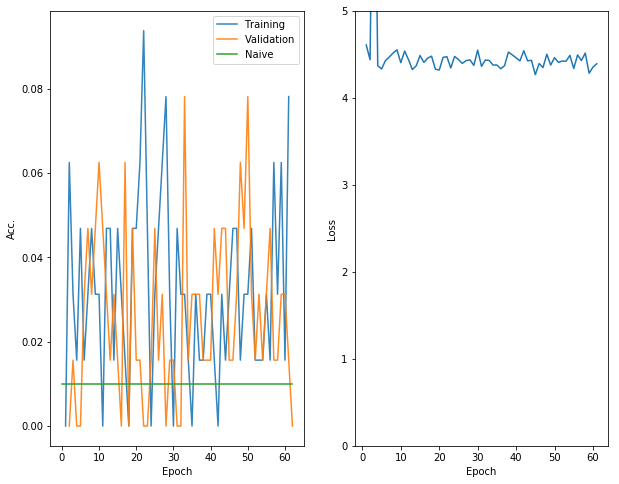

Step:  63  Train:  0.03125  Val:  0.046875 LR:  0.0039204


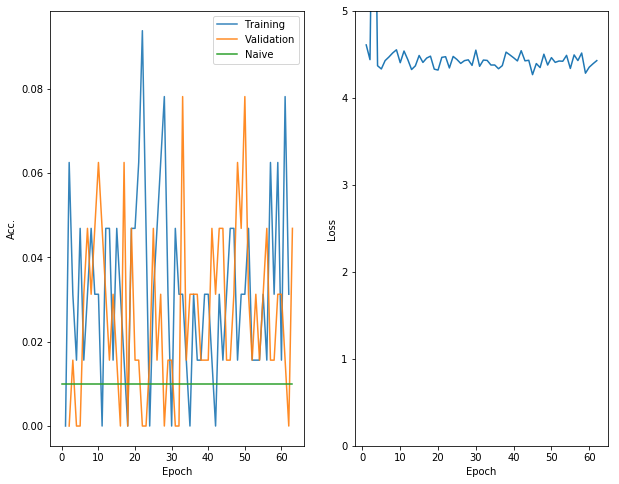

Step:  64  Train:  0.03125  Val:  0.03125 LR:  0.0039204


Step:  65  Train:  0.0  Val:  0.046875 LR:  0.0039204


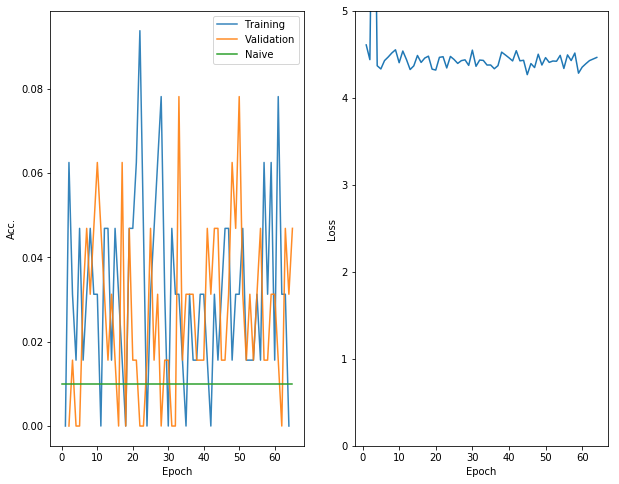

Step:  66  Train:  0.0625  Val:  0.03125 LR:  0.0039204


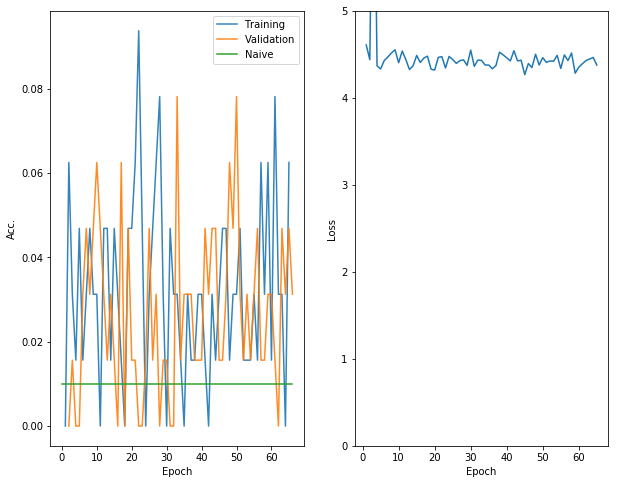

Step:  67  Train:  0.046875  Val:  0.03125 LR:  0.0039204


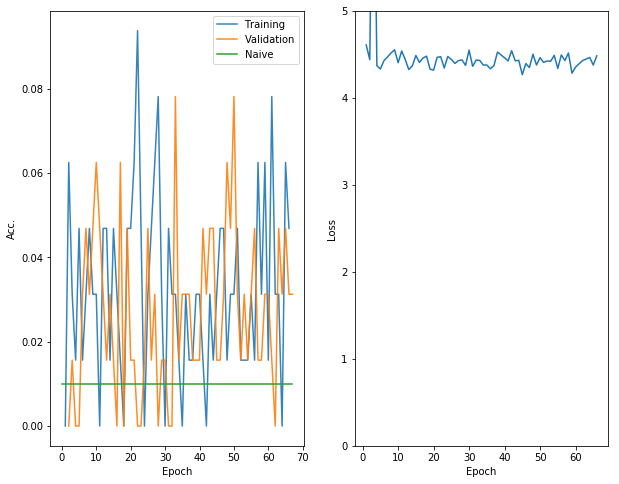

Step:  68  Train:  0.015625  Val:  0.015625 LR:  0.0039204


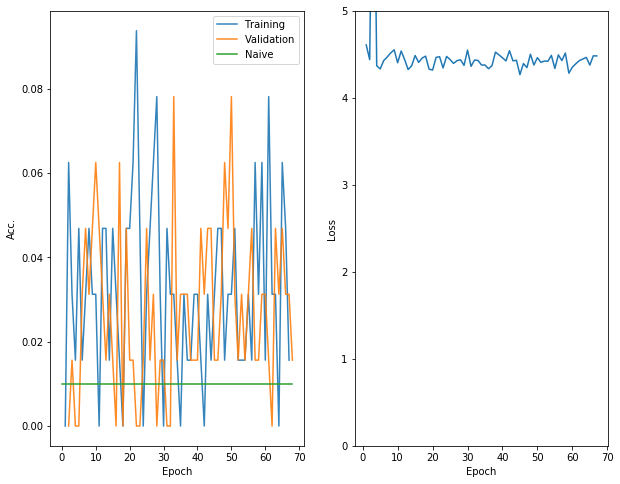

Step:  69  Train:  0.046875  Val:  0.078125 LR:  0.0039204


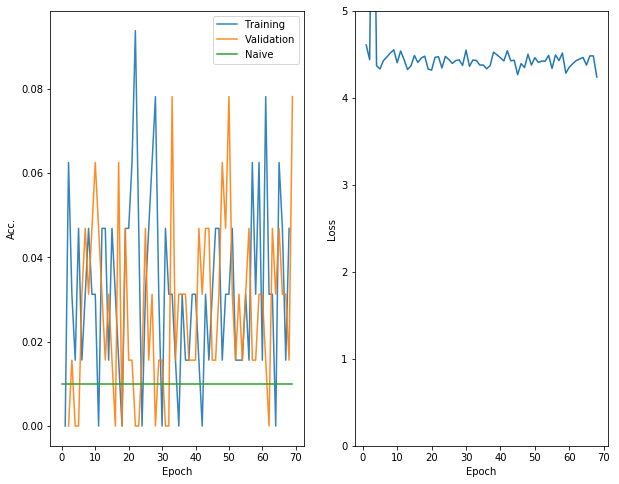

Step:  70  Train:  0.03125  Val:  0.03125 LR:  0.0039204


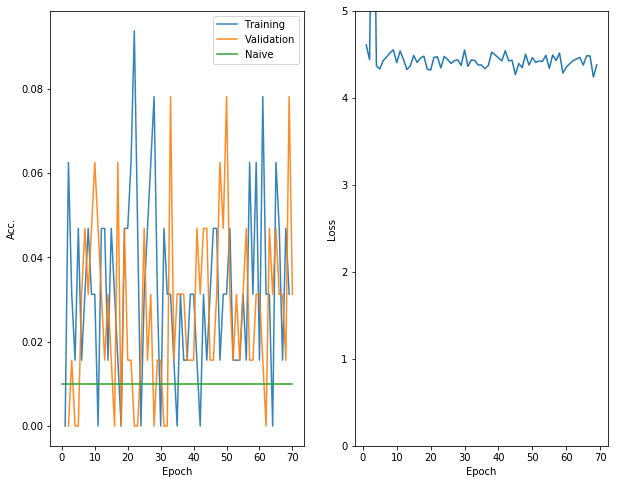

Step:  71  Train:  0.03125  Val:  0.03125 LR:  0.0039204


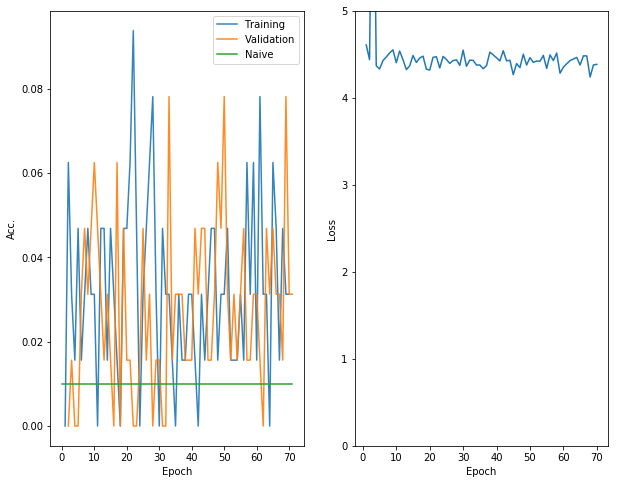

Step:  72  Train:  0.109375  Val:  0.046875 LR:  0.0039204


Step:  73  Train:  0.03125  Val:  0.03125 LR:  0.0039204


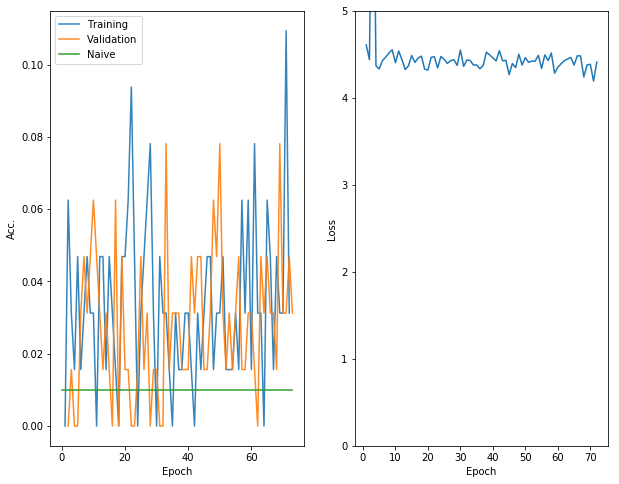

Step:  74  Train:  0.046875  Val:  0.015625 LR:  0.0039204


Step:  75  Train:  0.046875  Val:  0.03125 LR:  0.0039204


Step:  76  Train:  0.0625  Val:  0.046875 LR:  0.0039204


Step:  77  Train:  0.046875  Val:  0.03125 LR:  0.0039204


Step:  78  Train:  0.015625  Val:  0.015625 LR:  0.0039204


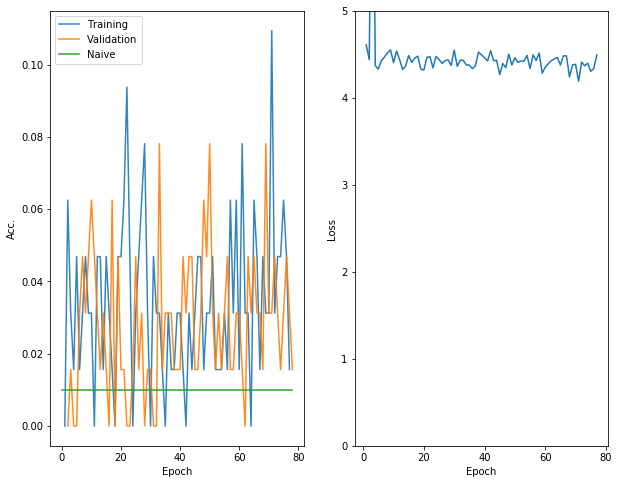

Step:  79  Train:  0.046875  Val:  0.015625 LR:  0.0039204


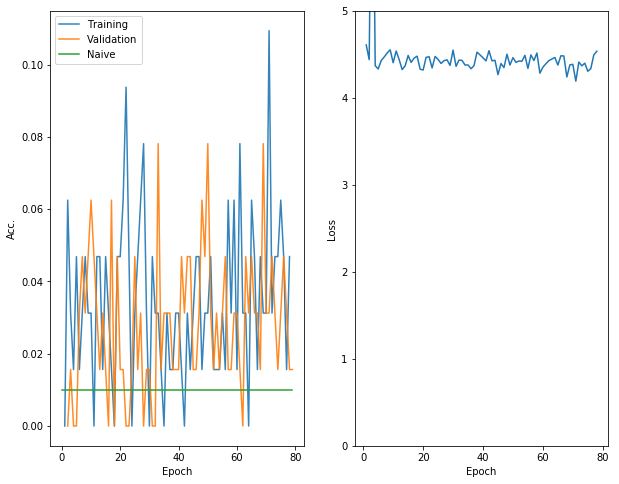

Step:  80  Train:  0.0  Val:  0.015625 LR:  0.0039204


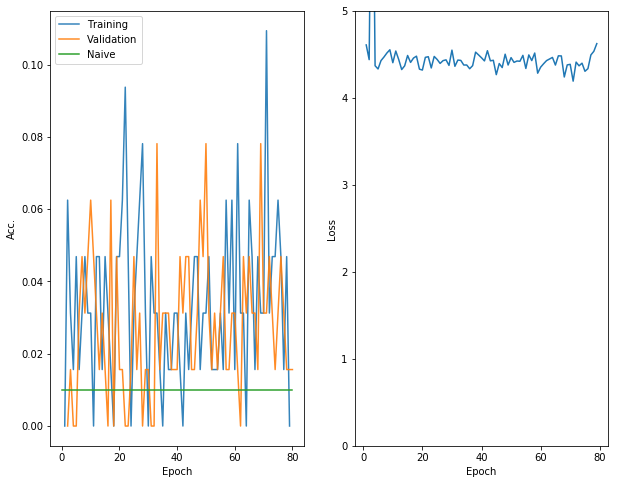

Step:  81  Train:  0.046875  Val:  0.0 LR:  0.0039204


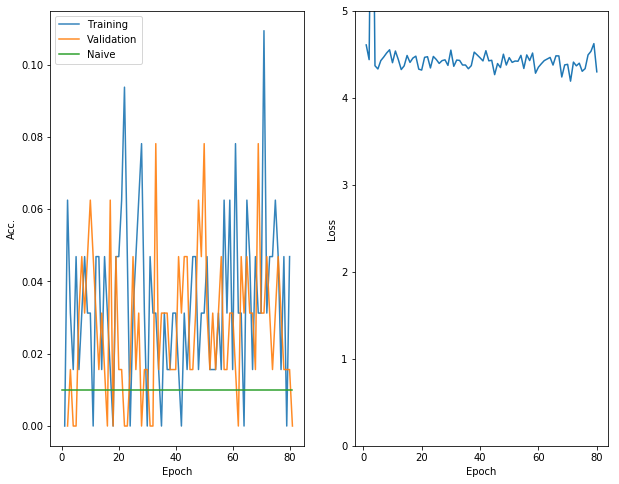

Step:  82  Train:  0.015625  Val:  0.015625 LR:  0.0039204


Step:  83  Train:  0.03125  Val:  0.03125 LR:  0.0039204


Step:  84  Train:  0.03125  Val:  0.078125 LR:  0.0039204


Step:  85  Train:  0.015625  Val:  0.03125 LR:  0.0039204


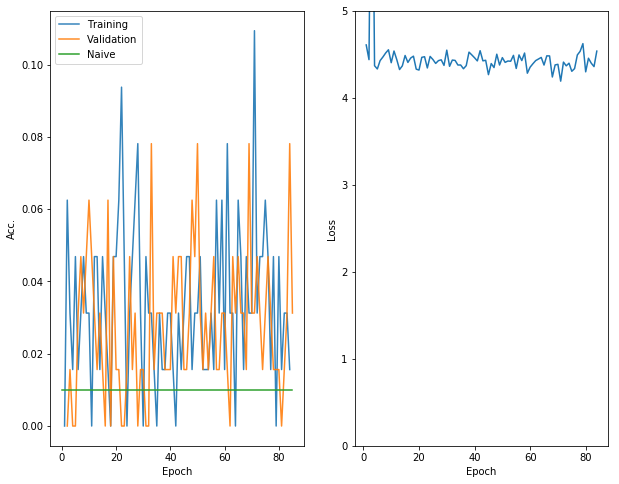

Step:  86  Train:  0.03125  Val:  0.015625 LR:  0.0039204


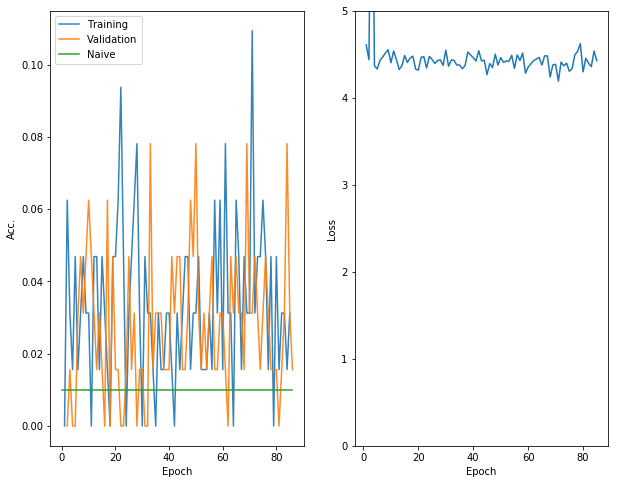

Step:  87  Train:  0.015625  Val:  0.03125 LR:  0.0039204


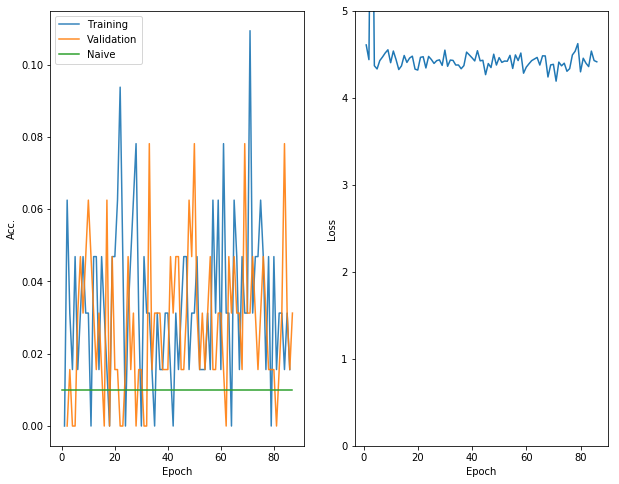

Step:  88  Train:  0.015625  Val:  0.015625 LR:  0.0039204


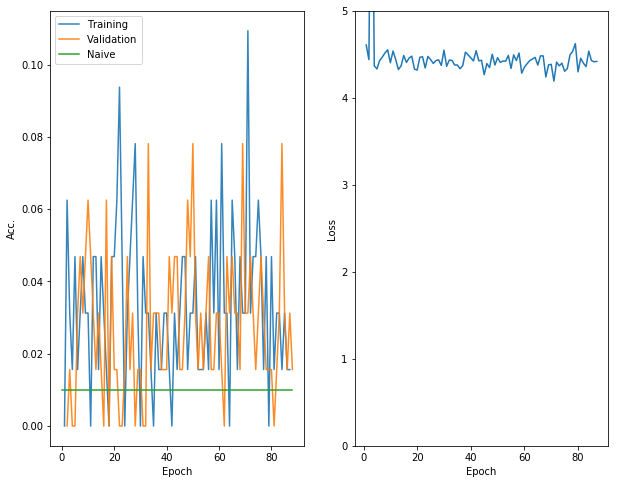

Step:  89  Train:  0.03125  Val:  0.0625 LR:  0.0039204


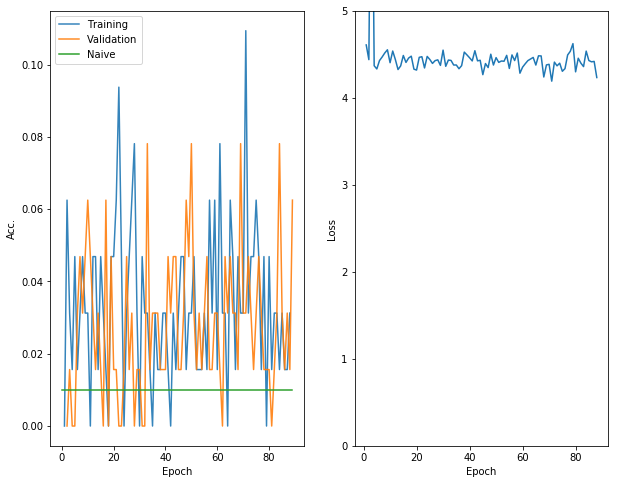

Step:  90  Train:  0.015625  Val:  0.09375 LR:  0.0039204


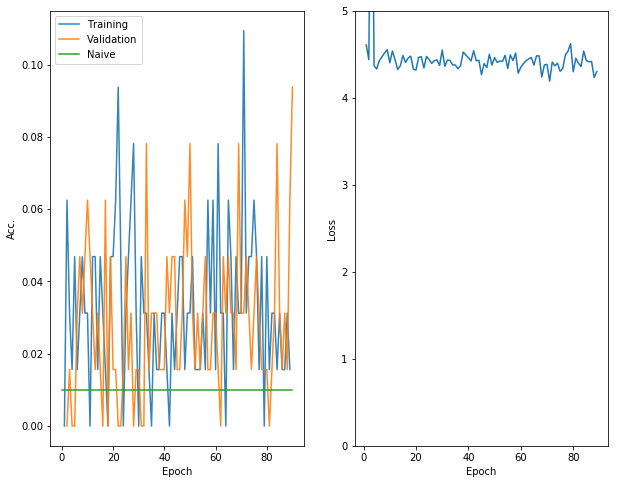

Step:  91  Train:  0.0  Val:  0.0625 LR:  0.003881196


Step:  92  Train:  0.03125  Val:  0.015625 LR:  0.003881196


Step:  93  Train:  0.015625  Val:  0.03125 LR:  0.003881196


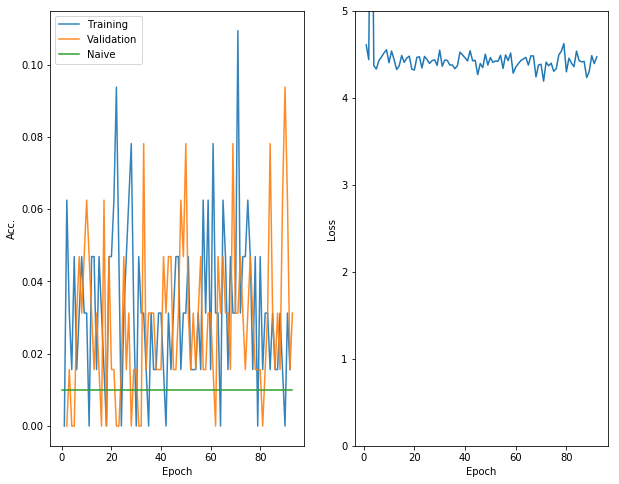

Step:  94  Train:  0.03125  Val:  0.078125 LR:  0.003881196


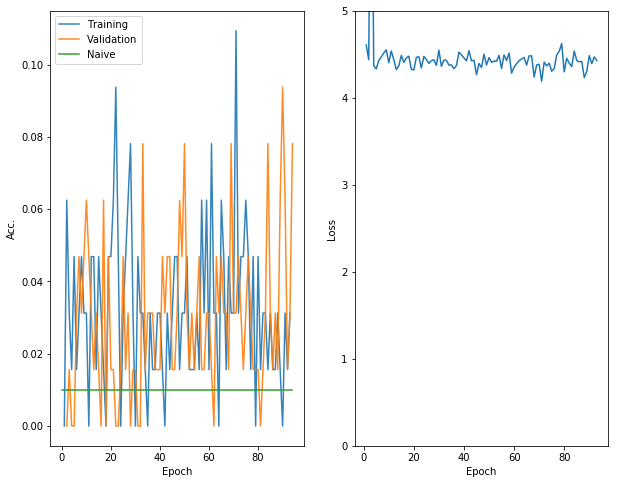

Step:  95  Train:  0.0625  Val:  0.015625 LR:  0.003881196


Step:  96  Train:  0.03125  Val:  0.0 LR:  0.003881196


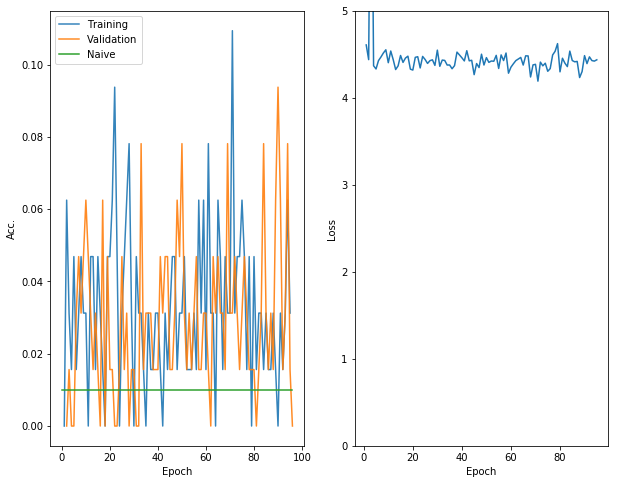

Step:  97  Train:  0.046875  Val:  0.046875 LR:  0.003881196


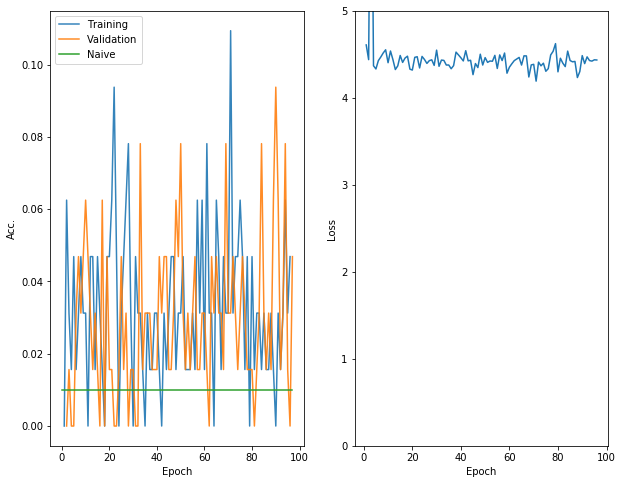

Step:  98  Train:  0.0625  Val:  0.0 LR:  0.003881196


Step:  99  Train:  0.046875  Val:  0.015625 LR:  0.003881196


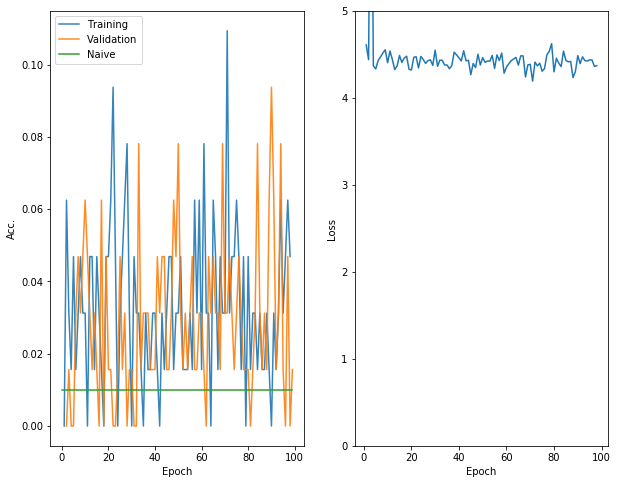

Step:  100  Train:  0.015625  Val:  0.0 LR:  0.003881196


Done.


In [14]:
tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# simple parameters:
disp_period = 1
training_iters = 100
lr = 0.004
lr_decay=0.99

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    model = SqueezeNet(sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    train_inds = []

    naive_val = 1/NUM_CLASSES
    
    # Launch the graph
    sess.run(init)
    step = 1
    loss_hist = []
    train_inds = []
    val_inds = []
    # Keep training until reach max iterations
    while step  < training_iters:
        if step % 30 is 0:
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y = sample_minibatch(BATCH_SIZE)        
        
#        print('Batch_y shape:', batch_y.shape)
        # Run optimization op (backprop)
#                self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
#        self.labels = tf.placeholder('int32', shape=[None], name='labels')
#        self.lr = tf.placeholder('float',shape[1],name='lr')

        o,loss,acc_t = sess.run([model.optimizer,model.loss, model.acc], feed_dict={model.image: batch_x, model.labels: batch_y, model.lr:[lr]})
        # Compute accuracy:
        train_inds.append(step)
        train_history.append(acc_t)
        loss_hist.append(loss)
        
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            batch_x, batch_y = sample_minibatch(BATCH_SIZE, False)
            acc_v = sess.run(model.acc, feed_dict={model.image: batch_x, model.labels: batch_y})
            val_history.append(acc_v)
            val_inds.append(step)
            
            print('Step: ', step, ' Train: ', acc_t, ' Val: ', acc_v,'LR: ', lr)
            plt.subplot(1,2,1)
            plt.plot(train_inds, train_history,alpha=0.9)
            plt.plot(val_inds, val_history,alpha=0.9)
            plt.plot([0,step], [naive_val,naive_val])
            plt.legend(['Training','Validation','Naive'])
            plt.xlabel('Epoch')
            plt.ylabel('Acc.')
            plt.subplot(1,2,2)
            plt.plot(train_inds,loss_hist)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.ylim([0,5])
            plt.show()
    # Compute sequence prediction:
print('Done.')


In [13]:
# Reconstruct signal using a randomwalk model:
print('Computing sequence prediction - this may take a while. ')
y_pred = np.zeros_like(y_data)

for k in range(0,flows_data.shape[0]-(flows_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
    if k % 1000 is 0:
        print('k = ', k)
    pred = sess.run(model.prediction, feed_dict={model.image: flows_data[k:k+BATCH_SIZE,:,:,:], model.labels: y_data[k:k+BATCH_SIZE]})
    y_pred[k:k+BATCH_SIZE] = pred
    


Computing sequence prediction - this may take a while. 
k =  0
k =  8000


In [141]:
reconstructed_signal= np.zeros(y_pred.shape[0])
for k in range(y_pred.shape[0]):
    c = np.int(y_pred[k])
    reconstructed_signal[k] =  std_vals[c]*np.random.randn()+mean_vals[c]
plt.plot(reconstructed_signal)
plt.plot(y_norm)
plt.legend(['Reconstructed','Original'])

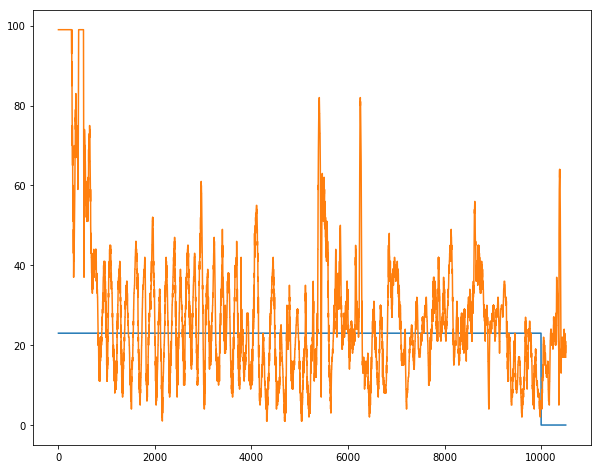

In [142]:
plt.plot(y_pred)
plt.plot(y_data)